In [1]:
import sys
from collections import Counter
import numpy as np

## Detection metrics: AP calculation

In [2]:
"""
based on https://github.com/rafaelpadilla/Object-Detection-Metrics/blob/master/lib/Evaluator.py
arguably more readable implementation (I hope)
"""

class BBoxInds:
    image_id_idx = 0
    confidence_idx = 1
    bbox = slice(2, 6)
    class_idx = 6
    
def calc_iou(bbox1, bbox2):
    return 1
    # TODO
    raise NotImplementedError()
    
def calc_ap11(recalls, precisions):
    mrec = [0] + recalls + [1]
    mpre = [0] + precisions + [0]
    
    ps_interpolated = []
    # For each recallValues (0, 0.1, 0.2, ... , 1)
    for r in np.linspace(0, 1, 11):
        at_least_r_indices = np.argwhere(mrec >= r)
        if len(at_least_r_indices) > 0:
            p_interpolated = np.max(mpre[at_least_r_indices.min():])
        else:
            p_interpolated = 0
        ps_interpolated.append(p_interpolated)
    return np.mean(ps_interpolated)
    
def calc_ap(recalls, precisions):
    # see https://github.com/rafaelpadilla/Object-Detection-Metrics for explanation and examples
    mrec = [0] + recalls + [1]
    mpre = [0] + precisions + [0]
    for i in range(len(mpre) - 1, 0, -1):
        # order is ascending; mpre[i] is now *max precision with recall at least recalls[i]*
        mpre[i - 1] = max(mpre[i - 1], mpre[i])
    ii = []  # compute average among *points where recall changes*
    for i in range(len(mrec) - 1):
        if mrec[1:][i] != mrec[0:-1][i]:
            ii.append(i + 1)
    
    # ap = sum(max_precision_in_range * range_length)
    ap = 0
    for i in ii:
        ap = ap + np.sum((mrec[i] - mrec[i - 1]) * mpre[i])
    return ap

def calc_metrics(ground_truths, detections, iou_threshold=0.5, use_all_points=True):
    """
    each object in `ground_truths` and `detections` should have same format as in BBoxInds
    """
    # gt[0] is assumed to be (image_id, class_name_or_id, confidence, bbox, *)
    class2metrics = dict()
    # Get all classes
    classes = np.unique([b[BBoxInds.class_idx] for b in ground_truths]).tolist()
    
    classes = sorted(classes)
    # Precision x Recall is obtained individually by each class
    # Loop through by classes
    for c in classes:
        # Get only detection of class c
        dts = [d for d in detections if d[BBoxInds.class_idx] == c]
        # Get only ground truths of class c
        gts = [g for g in ground_truths if g[BBoxInds.class_idx] == c]
        npos = len(gts)
        # sort detections by decreasing confidence
        dts = sorted(dts, key=lambda bbox: bbox[BBoxInds.confidence_idx], reverse=True)
        TP = np.zeros(len(dts))
        FP = np.zeros(len(dts))
        
        # dict: image_id -> array(gt_in_image_idx -> was_detected?)
        already_detected = Counter([bbox[BBoxInds.image_id_idx] for bbox in gts])
        for key, val in already_detected.items():
            already_detected[key] = np.zeros(val)
        
        # for each detected object
        for d_idx, d in enumerate(dts):
            
            # find all gt objects *on the same image*
            same_image_gt = [gt for gt in gts if gt[BBoxInds.image_id_idx] == d[BBoxInds.image_id_idx]]
            # among these gt objects find the one with max IoU
            d2gt_ious = [calc_iou(d[BBoxInds.bbox], g[BBoxInds.bbox]) for g in same_image_gt]
            max_iou_idx = np.argmax(d2gt_ious)
            max_iou = d2gt_ious[max_iou_idx]
            # mark detection as true positive/false positive
            if max_iou >= iou_threshold:
                # found gt object with IoU >= threshold
                if already_detected[d[BBoxInds.image_id_idx]][max_iou_idx] == 0:
                    # this gt object has not been marked yet by previous (more confident) detections
                    TP[d_idx] = 1  # count as true positive
                    already_detected[d[BBoxInds.image_id_idx]][max_iou_idx] = 1
                else:
                    # it was marked by previous detections
                    FP[d_idx] = 1  # count as false positive
            else:
                # no gt with IoU >= threshold --> FP
                FP[d_idx] = 1  # count as false positive
                # print("FP")
        
        # compute precision, recall and average precision
        acc_FP = np.cumsum(FP)
        acc_TP = np.cumsum(TP)
        recalls = acc_TP / npos
        precisions = np.divide(acc_TP, (acc_FP + acc_TP))
        # depending on the method, call the right implementation
        if use_all_points:
            ap = calc_ap(recalls, precisions)
        else:
            ap = calc_ap11(recalls, precisions)
        # add class result in the dictionary to be returned
        class2metrics[c] = {
            'precisions': precisions,
            'recalls': recalls,
            'AP': ap,
            'total gt objects': npos,
            'total TP': np.sum(TP),
            'total FP': np.sum(FP)
        }
    return class2metrics

In [3]:
dts = [
    ('img1', .88, 5, 67, 31, 48, 'person'),
    ('img2', .70, 119, 111, 40, 67, 'person'),
    ('img1', .80, 124, 9, 49, 67, 'cat')
]

gts = [
    ('img1', .88, 5, 67, 31, 48, 'person'),
    ('img2', .70, 119, 111, 40, 67, 'person'),
    ('img1', .80, 124, 9, 49, 67, 'cat')
]

calc_metrics(gts, dts)

{'cat': {'precisions': array([1.]),
  'recalls': array([1.]),
  'AP': 0,
  'total gt objects': 1,
  'total TP': 1.0,
  'total FP': 0.0},
 'person': {'precisions': array([1., 1.]),
  'recalls': array([0.5, 1. ]),
  'AP': 0.5,
  'total gt objects': 2,
  'total TP': 2.0,
  'total FP': 0.0}}

## The dataset
We will use [Penn-Fudan Database for Pedestrian Detection and Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/).

It contains 170 images with 345 instances of pedestrians

In [4]:
# # download the Penn-Fudan dataset
# !wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# # extract it in the current folder
# !unzip -q PennFudanPed.zip -d .

In [5]:
import os
import numpy as np
import torch
import torch.utils.data
import cv2


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            y_min, x_min = np.min(pos, axis=1)
            y_max, x_max = np.max(pos, axis=1)
            # yolo format [x_c, y_c, width, height] (here not normalized!)
            x_c = (x_min + x_max) / 2.
            y_c = (y_min + y_max) / 2.
            class_id_dummy = 0  # must be specified for albumentation but we do not use classification
            boxes.append([x_c, y_c, x_max - x_min, y_max - y_min, class_id_dummy])

        #boxes = torch.as_tensor(boxes, dtype=torch.float32)

#         image_id = torch.tensor([idx])
#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
#         # suppose all instances are not crowd
#         iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

#         target = {}
#         target["boxes"] = boxes
#         target["labels"] = labels
#         target["image_id"] = image_id
#         target["area"] = area
#         target["iscrowd"] = iscrowd

        dict_ = {
            "image": img,
            "image_name": self.imgs[idx],
            "bboxes": boxes
        }
        if self.transforms is not None:
            dict_ = self.transforms(dict_)

        return dict_

    def __len__(self):
        return len(self.imgs)

In [6]:
dataset = PennFudanDataset('./PennFudanPed')

[[230.0, 305.5, 142, 249, 0], [476.5, 327.5, 115, 315, 0]]


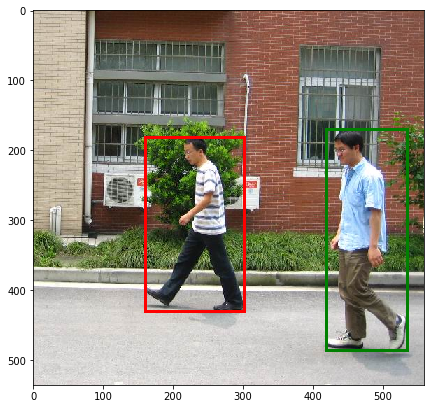

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def draw_bboxes_on_img(img, bboxes):
    plt.figure(figsize=(7,10))
    plt.imshow(img)
    color_palette = 'rgbcmyk'
    for i in range(len(bboxes)):
        rect = bboxes[i]
        rect = [rect[0] - rect[2] / 2., rect[1] - rect[3] / 2] + rect[2:-1]
        plt.gca().add_artist(
          plt.Rectangle(rect[:2], rect[2], rect[3],
                        fill=False, color=color_palette[i], linewidth=3)
          )
    plt.show()
    

image, bboxes = dataset[0]['image'], dataset[0]['bboxes']
print(bboxes)
draw_bboxes_on_img(image, bboxes)

## Augmentations

In [8]:
import albumentations as A
from albumentations import (
    ChannelShuffle, CLAHE, Compose, HueSaturationValue, IAAPerspective,
    JpegCompression, LongestMaxSize, Normalize, OneOf, PadIfNeeded,
    RandomBrightnessContrast, RandomGamma, RGBShift, ShiftScaleRotate, ToGray
)
from albumentations.pytorch import ToTensor
from albumentations.augmentations import bbox_utils


def _add_transform_default_params(kwargs):
    # take a look at https://albumentations.readthedocs.io/en/latest/api/core.html#albumentations.core.composition.BboxParams
    if "bbox_params" not in kwargs:
        kwargs["bbox_params"] = {'format': 'yolo'}
    return kwargs


def pre_transforms(image_size: int = 256, **kwargs):
    """Transforms that always be applied before other transformations"""
    _add_transform_default_params(kwargs)

    transforms = Compose([
        LongestMaxSize(max_size=image_size),
        PadIfNeeded(
            image_size, image_size, border_mode=cv2.BORDER_CONSTANT
        ),
    ], **kwargs)
    return transforms


def post_transforms():
    """Transforms that always be applied after all other transformations"""
    return Compose([Normalize(), ToTensor()])


def hard_transform(image_size: int = 256, p: float = 0.5, **kwargs):
    """Hard augmentations"""
    _add_transform_default_params(kwargs)

    transforms = Compose([
        ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.1,
            rotate_limit=15,
            border_mode=cv2.BORDER_REFLECT,
            p=p,
        ),
        IAAPerspective(scale=(0.02, 0.05), p=p),
        OneOf([
            HueSaturationValue(p=p),
            ToGray(p=p),
            RGBShift(p=p),
            ChannelShuffle(p=p),
        ]),
        RandomBrightnessContrast(
            brightness_limit=0.5, contrast_limit=0.5, p=p
        ),
        RandomGamma(p=p),
        CLAHE(p=p),
        JpegCompression(quality_lower=50, p=p),
    ], **kwargs)
    return transforms

## The beginning of the mess
All the remaining notebooks is pretty much a draft

### the next block of code is used to just get the datasets, do not bother with this Experiment successor really

In [9]:
from collections import OrderedDict
from torch.utils.data import Subset, DataLoader

import catalyst
from catalyst.dl.experiment import BaseExperiment
from catalyst.data.collate_fn import FilteringCollateFn

collate_fn = FilteringCollateFn("bboxes")

class SimpleExperiment(BaseExperiment):
    def __init__(
        self,
        model,
        batch_size: int = 8,
        **kwargs
#         callbacks: "Union[OrderedDict[str, Callback], List[Callback]]" = None,
#         logdir: str = None,
#         stage: str = "train",
#         criterion: _Criterion = None,
#         optimizer: _Optimizer = None,
#         scheduler: _Scheduler = None,
#         num_epochs: int = 1,
#         valid_loader: str = "valid",
#         main_metric: str = "loss",
#         minimize_metric: bool = True,
#         verbose: bool = False,
#         state_kwargs: Dict = None,
#         checkpoint_data: Dict = None,
#         distributed_params: Dict = None,
#         monitoring_params: Dict = None,
#         initial_seed: int = 42,
    ):
        super().__init__(
            model=model,
            loaders=None,
            **kwargs
#             callbacks=callbacks,
#             logdir=logdir,
#             stage=stage,
#             criterion=criterion,
#             optimizer=optimizer,
#             scheduler=scheduler,
#             num_epochs=num_epochs,
#             valid_loader=valid_loader,
#             main_metric=main_metric,
#             minimize_metric=minimize_metric,
#             verbose=verbose,
#             state_kwargs=state_kwargs,
#             checkpoint_data=checkpoint_data,
#             distributed_params=distributed_params,
#             monitoring_params=monitoring_params,
#             initial_seed=initial_seed
        )
        
    @staticmethod
    def get_transforms(stage: str = None, mode: str = None, image_size: int = 256):
        pre_transform_fn = pre_transforms(image_size=image_size)

        if mode == "train":
            post_transform_fn = Compose([
                hard_transform(image_size=image_size),
                post_transforms(),
            ])
        elif mode in ["valid", "infer"]:
            post_transform_fn = post_transforms()
        else:
            raise NotImplementedError()

        transform_fn = Compose([pre_transform_fn, post_transform_fn])

        def process(dict_):
            rows, cols = dict_["image"].shape[:2]
            dict_["bboxes"] = bbox_utils.normalize_bboxes(dict_["bboxes"], rows=rows, cols=cols)
            result = transform_fn(**dict_)
            # TODO: handle mask generation from bbox
            return result

        return process
    
    def get_datasets(self, valid_size=0.2, test_size=0):
        train_transforms = self.get_transforms(mode="train")
        val_transforms = self.get_transforms(mode="valid")
        
        dataset = PennFudanDataset('./PennFudanPed', transforms=val_transforms)
        
        n_images = len(dataset)
        test_size = int(test_size * n_images)
        valid_size = int(valid_size * n_images)
        train_size = n_images - valid_size - test_size
        
        shuffled_indices = np.arange(n_images)
        np.random.shuffle(shuffled_indices)
        datasets = OrderedDict()
        datasets["train"] = Subset(dataset, shuffled_indices[:train_size])
        datasets["valid"] = Subset(dataset, shuffled_indices[train_size:][:valid_size])
        datasets["test"] = Subset(dataset, shuffled_indices[train_size:][valid_size:])
        
        datasets["train"].transforms = train_transforms  # clearly hacky way, but it's 11pm a day before seminar, so as always...
        return datasets
        
    def get_loaders(self, batch_size=1, num_workers=0, collate_fn=collate_fn):
        loaders = OrderedDict()
        for key, dataset in self.get_datasets().items():
            loaders[key] = DataLoader(dataset, 
                                      shuffle=key.startswith("train"), 
                                      batch_size=batch_size, 
                                      num_workers=num_workers,
                                      collate_fn=collate_fn
                                     )
        return loaders
            
e = SimpleExperiment(None)

In [10]:
l = e.get_loaders()["train"]
for batch_dict in l:
    print(batch_dict)
    break

{'image': tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


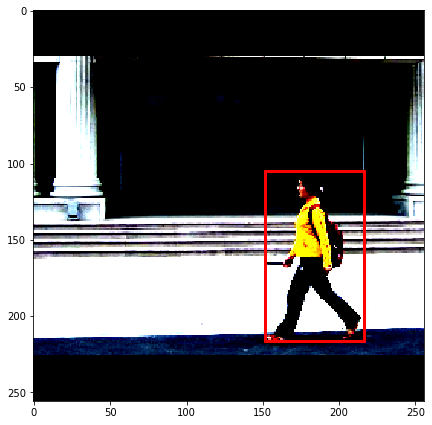

In [11]:
import matplotlib.pyplot as plt
def draw_bboxes_on_img(img, bboxes):
    plt.figure(figsize=(7,10))
    plt.imshow(img)
    color_palette = 'rgbcmyk'
    for i in range(len(bboxes)):
        rect = [val1 * val2 for val1, val2 in zip(bboxes[i], img.shape[:2] + img.shape[:2])]
        rect = [rect[0] - rect[2] / 2., rect[1] - rect[3] / 2.] + rect[2:]
        plt.gca().add_artist(
          plt.Rectangle(rect[:2], rect[2], rect[3],
                        fill=False, color=color_palette[i], linewidth=3)
          )
    plt.show()
    
images = batch_dict["image"].numpy().transpose((0, 2, 3, 1))
bboxes = batch_dict["bboxes"]
for i in range(len(images)):
    draw_bboxes_on_img(images[i], bboxes[i])

In [12]:
d = l.dataset

### now let's move to [Detectron2](https://github.com/facebookresearch/detectron2)

### calculating YOLO targets
the remaining part is based on [pytorch YOLOv3 implementation](https://github.com/eriklindernoren/PyTorch-YOLOv3/tree/47b7c912877ca69db35b8af3a38d6522681b3bb3)

In [68]:
def bbox_wh_iou(wh1, wh2, transpose=True):
    if transpose:
        wh2 = wh2.t()
    w1, h1 = wh1[0], wh1[1]
    w2, h2 = wh2[0], wh2[1]
    inter_area = torch.min(w1, w2) * torch.min(h1, h2)
    union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
    return inter_area / union_area


def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

def calc_targets(dict_, 
                 scale=8, 
                 anchors=[(10, 10), (10, 20), (10, 30)], 
                 ignore_thresh=0.5,
                 prefix="",
                 suffix="",
                ):
    """
    bboxes -> YOLO grid targets
    """
    ## PREPROCESSING (computing targets)
#     h, w = dict_["image"].size()[-2:]
#     #
#     normed_bboxes = dict_["bboxes"]
#     #
#     n_x_cells = h / scale
#     n_y_cells = w / scale
#     #
#     gt_cells_grid_indices = [(bbox[0] * n_x_cells, bbox[1] * n_y_cells) for bbox in normed_bboxes]
#     gt_cells_grid_indices = np.floor(gt_cells_grid_indices)
    #
#     print(list(zip(normed_bboxes, gt_cells_grid_indices)))
#     grid = np.zeros
    CUDA = False
    device = "cuda" if CUDA else "cpu"

    ByteTensor = torch.cuda.ByteTensor if CUDA else torch.ByteTensor
    FloatTensor = torch.cuda.FloatTensor if CUDA else torch.FloatTensor
    
    images = dict_["image"]
    anchors = torch.tensor(anchors, device=device, dtype=torch.float)

    nB = images.size(0)
    nA = torch.tensor(len(anchors), device=device, dtype=torch.long)
#     nC = pred_cls.size(-1)  # we do not have classes in this notebook
    nG = images.size(2) // scale  # let't assume nx_cells == ny_cells for simplicity (square images only)

    # Output tensors
    obj_mask = ByteTensor(nB, nA, nG, nG).fill_(0)
    noobj_mask = ByteTensor(nB, nA, nG, nG).fill_(1)
#     class_mask = FloatTensor(nB, nA, nG, nG).fill_(0)
    iou_scores = FloatTensor(nB, nA, nG, nG).fill_(0)
    tx = FloatTensor(nB, nA, nG, nG).fill_(0)
    ty = FloatTensor(nB, nA, nG, nG).fill_(0)
    tw = FloatTensor(nB, nA, nG, nG).fill_(0)
    th = FloatTensor(nB, nA, nG, nG).fill_(0)
#     tcls = FloatTensor(nB, nA, nG, nG, nC).fill_(0)

    b_bboxes = torch.tensor(
        [[batch_id] + bbox[:4] for batch_id, bboxes in enumerate(dict_["bboxes"]) for bbox in bboxes]
    )  # b,x,y,w,h

    # Convert to position relative to box
    target_boxes = b_bboxes[:, 1:5] * nG
    b = b_bboxes[:, 0]
    gxy = target_boxes[:, :2]
    gwh = target_boxes[:, 2:]
    # Get anchors with best iou
    ious = torch.stack([bbox_wh_iou(anchor, gwh, transpose=True) for anchor in anchors])
    best_ious, best_n = ious.max(0)
    # Separate target values
    b = b_bboxes[:, 0].long()
    gx, gy = gxy.t()
    gw, gh = gwh.t()
    gi, gj = gxy.long().t()
    # Set masks TODO: double check that masks are correct (gj, gi and not gi, gj)
    obj_mask[b, best_n, gj, gi] = 1
    noobj_mask[b, best_n, gj, gi] = 0

    # Set noobj mask to zero where iou exceeds ignore threshold
    for i, anchor_ious in enumerate(ious.t()):
        noobj_mask[b[i], anchor_ious > ignore_thresh, gj[i], gi[i]] = 0
        
    # Coordinates
    ### POSTPROCESSING
#     tx[b, best_n, gj, gi] = gx - gx.floor()
#     ty[b, best_n, gj, gi] = gy - gy.floor()
#     # Width and height
#     tw[b, best_n, gj, gi] = torch.log(gw / anchors[best_n][:, 0] + 1e-16)
#     th[b, best_n, gj, gi] = torch.log(gh / anchors[best_n][:, 1] + 1e-16)
    
    # Coordinates
    tx = gx - gx.floor()
    ty = gy - gy.floor()
    # Width and height
    tw = torch.log(gw / anchors[best_n][:, 0] + 1e-16)
    th = torch.log(gh / anchors[best_n][:, 1] + 1e-16)
    # One-hot encoding of label
    ##tcls[b, best_n, gj, gi, target_labels] = 1
    # Compute label correctness and iou at best anchor
    ### METRICS
#     class_mask[b, best_n, gj, gi] = (pred_cls[b, best_n, gj, gi].argmax(-1) == target_labels).float()
#     iou_scores[b, best_n, gj, gi] = bbox_iou(pred_boxes[b, best_n, gj, gi], target_boxes, x1y1x2y2=False)

    tconf = obj_mask.float()
    
    return {
        f"{prefix}tx{suffix}": tx,
        f"{prefix}ty{suffix}": ty,
        f"{prefix}tw{suffix}": tw,
        f"{prefix}th{suffix}": th,
        f"{prefix}tconf{suffix}": tconf,
        f"{prefix}obj_mask{suffix}": obj_mask,
        f"{prefix}noobj_mask{suffix}": noobj_mask,
        
        f"{prefix}target_bboxes{suffix}": target_boxes,
        f"{prefix}anchor_indices{suffix}": torch.stack([b, best_n, gj, gi], dim=0),
    }
#     return iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf

def process_raw_predictions(output, state_input, 
                            scale=8, anchors=[(10, 10), (10, 20), (10, 30)], prefix="", suffix=""):
    """
    network outputs -> yolo predictions (for both loss computation & inference detection bboxes processing)
    """
    logits, predictions, pred_conf = output
    logits = logits.cpu()
    predictions = predictions.cpu()
    # logits.shape == (num_samples, self.num_anchors, self.num_classes + 5, grid_size, grid_size)
    # predictions.shape == (num_samples, self.num_anchors, grid_size, grid_size, self.num_classes + 5)
    
    true_anchor_indices = state_input[f"{prefix}anchor_indices{suffix}"]
    b, best_n, gj, gi = true_anchor_indices.cpu()
    # output.size() == (b, a*(n_classes+5), grid_h, grid_w)
    
    confidence_threshold = 0.5
#     result = output.view(output.size(0), len(anchors), -1, output.size(-2), output.size(-1)).contiguous()
#     result = result.transpose((0, -2, -1, 1, 2))
    assert predictions.size(-1) == 5
    tconf = predictions[..., 4].cpu()
    assert pred_conf.numel() == state_input[f"{prefix}obj_mask"].numel() == state_input[f"{prefix}noobj_mask"].numel() == state_input[f"{prefix}tconf"].numel(),\
        str((tconf.size(), state_input[f"{prefix}obj_mask"].size(), state_input[f"{prefix}noobj_mask"].size(), state_input[f"{prefix}tconf"].size()))
    assert tconf.min() >= 0 and tconf.max() <= 1, f"(min={tconf.min()}, max={tconf.max()})"
    detected_bboxes = [predictions[i][tconf[i] > confidence_threshold] for i in range(predictions.size(0))]
    
    print(logits.size(), b.size(), best_n.size(), gj.size(), gi.size(),
         "max:", b.max(), best_n.max(), gj.max(), gi.max(), "dtype:", b.dtype)
    print(state_input.keys(), prefix, scale)
    return {
        f"{prefix}tx{suffix}": logits[b, best_n*5, gj, gi],
        f"{prefix}ty{suffix}": logits[b, best_n*5+1, gj, gi],
        f"{prefix}tw{suffix}": logits[b, best_n*5+2, gj, gi],
        f"{prefix}th{suffix}": logits[b, best_n*5+3, gj, gi],
        f"{prefix}tconf{suffix}": tconf,
        
        f"{prefix}detected_bboxes{suffix}": detected_bboxes,
    }
    
  
# calc_targets(d[0])
calc_targets(batch_dict)

{'tx': tensor([0.1793, 0.2837]),
 'ty': tensor([0.3330, 0.9577]),
 'tw': tensor([-0.5860, -0.5736]),
 'th': tensor([ 0.0234, -0.1871]),
 'tconf': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'obj_mask': tensor([[[

In [69]:
from torch import nn
# you should be familiar with ResNet18 which we have implemented during seminar3
def conv3x3(ch_in, ch_out, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(ch_in, ch_out, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride, bias=False)


class YOLOLayer(nn.Module):
    """Detection layer"""

    def __init__(self, ch_in, anchors, num_classes, stride):
        super(YOLOLayer, self).__init__()
        self.predictor = conv1x1(ch_in, len(anchors) * (num_classes + 5))
        
        self.anchors = anchors
        self.num_anchors = len(anchors)
        self.num_classes = num_classes
#         self.ignore_thres = 0.5
#         self.mse_loss = nn.MSELoss()
#         self.bce_loss = nn.BCELoss()
#         self.obj_scale = 1
#         self.noobj_scale = 100
# #         self.metrics = {}
        self.stride = stride
        self.grid_size = 0  # grid size

    def compute_grid_offsets(self, grid_size, cuda=False):
        self.grid_size = grid_size
        g = self.grid_size
        FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
#         print(self.img_dim, self.grid_size)
#         self.stride = self.img_dim / self.grid_size
        # Calculate offsets for each grid
        self.grid_x = torch.arange(g).repeat(g, 1).view([1, 1, g, g]).type(FloatTensor)
        self.grid_y = torch.arange(g).repeat(g, 1).t().view([1, 1, g, g]).type(FloatTensor)
        self.scaled_anchors = FloatTensor([(a_w / self.stride, a_h / self.stride) for a_w, a_h in self.anchors])
        self.anchor_w = self.scaled_anchors[:, 0:1].view((1, self.num_anchors, 1, 1))
        self.anchor_h = self.scaled_anchors[:, 1:2].view((1, self.num_anchors, 1, 1))

    def forward(self, x):
        x = self.predictor(x)
        logits = x

        # Tensors for cuda support
        FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
        LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
        ByteTensor = torch.cuda.ByteTensor if x.is_cuda else torch.ByteTensor

#         self.img_dim = img_dim
        num_samples = x.size(0)
        grid_size = x.size(2)

        prediction = (
            x.view(num_samples, self.num_anchors, self.num_classes + 5, grid_size, grid_size)
            .permute(0, 1, 3, 4, 2)
            .contiguous()
        )

        # Get outputs
        x = torch.sigmoid(prediction[..., 0])  # Center x
        y = torch.sigmoid(prediction[..., 1])  # Center y
        w = prediction[..., 2]  # Width
        h = prediction[..., 3]  # Height
        pred_conf = torch.sigmoid(prediction[..., 4])  # Conf
#         pred_cls = torch.sigmoid(prediction[..., 5:])  # Cls pred.

        # If grid size does not match current we compute new offsets
        if grid_size != self.grid_size:
            self.compute_grid_offsets(grid_size, cuda=x.is_cuda)

        # Add offset and scale with anchors
        pred_boxes = FloatTensor(prediction[..., :4].shape)
        pred_boxes[..., 0] = x.data + self.grid_x
        pred_boxes[..., 1] = y.data + self.grid_y
        pred_boxes[..., 2] = torch.exp(w.data) * self.anchor_w
        pred_boxes[..., 3] = torch.exp(h.data) * self.anchor_h

        output = torch.cat(
            (
                pred_boxes.view(num_samples, -1, 4) * self.stride,
                pred_conf.view(num_samples, -1, 1),
#                 pred_cls.view(num_samples, -1, self.num_classes),
            ),
            -1,
        )
        
        return logits, output, pred_conf

#         if targets is None:
#             return output, 0
#         else:
#             iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf = build_targets(
#                 pred_boxes=pred_boxes,
#                 pred_cls=pred_cls,
#                 target=targets,
#                 anchors=self.scaled_anchors,
#                 ignore_thres=self.ignore_thres,
#             )

#             # Loss : Mask outputs to ignore non-existing objects (except with conf. loss)
#             loss_x = self.mse_loss(x[obj_mask], tx[obj_mask])
#             loss_y = self.mse_loss(y[obj_mask], ty[obj_mask])
#             loss_w = self.mse_loss(w[obj_mask], tw[obj_mask])
#             loss_h = self.mse_loss(h[obj_mask], th[obj_mask])
#             loss_conf_obj = self.bce_loss(pred_conf[obj_mask], tconf[obj_mask])
#             loss_conf_noobj = self.bce_loss(pred_conf[noobj_mask], tconf[noobj_mask])
#             loss_conf = self.obj_scale * loss_conf_obj + self.noobj_scale * loss_conf_noobj
#             loss_cls = self.bce_loss(pred_cls[obj_mask], tcls[obj_mask])
#             total_loss = loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls

#             # Metrics
#             cls_acc = 100 * class_mask[obj_mask].mean()
#             conf_obj = pred_conf[obj_mask].mean()
#             conf_noobj = pred_conf[noobj_mask].mean()
#             conf50 = (pred_conf > 0.5).float()
#             iou50 = (iou_scores > 0.5).float()
#             iou75 = (iou_scores > 0.75).float()
#             detected_mask = conf50 * class_mask * tconf
#             precision = torch.sum(iou50 * detected_mask) / (conf50.sum() + 1e-16)
#             recall50 = torch.sum(iou50 * detected_mask) / (obj_mask.sum() + 1e-16)
#             recall75 = torch.sum(iou75 * detected_mask) / (obj_mask.sum() + 1e-16)

#             self.metrics = {
#                 "loss": to_cpu(total_loss).item(),
#                 "x": to_cpu(loss_x).item(),
#                 "y": to_cpu(loss_y).item(),
#                 "w": to_cpu(loss_w).item(),
#                 "h": to_cpu(loss_h).item(),
#                 "conf": to_cpu(loss_conf).item(),
#                 "cls": to_cpu(loss_cls).item(),
#                 "cls_acc": to_cpu(cls_acc).item(),
#                 "recall50": to_cpu(recall50).item(),
#                 "recall75": to_cpu(recall75).item(),
#                 "precision": to_cpu(precision).item(),
#                 "conf_obj": to_cpu(conf_obj).item(),
#                 "conf_noobj": to_cpu(conf_noobj).item(),
#                 "grid_size": grid_size,
#             }

#             return output, total_loss


# class Darknet(nn.Module):
#     """YOLOv3 object detection model"""

#     def __init__(self, config_path, img_size=416):
#         super(Darknet, self).__init__()
#         self.module_defs = parse_model_config(config_path)
#         self.hyperparams, self.module_list = create_modules(self.module_defs)
#         self.yolo_layers = [layer[0] for layer in self.module_list if hasattr(layer[0], "metrics")]
#         self.img_size = img_size
#         self.seen = 0
#         self.header_info = np.array([0, 0, 0, self.seen, 0], dtype=np.int32)

#     def forward(self, x, targets=None):
#         img_dim = x.shape[2]
#         loss = 0
#         layer_outputs, yolo_outputs = [], []
#         for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
#             if module_def["type"] in ["convolutional", "upsample", "maxpool"]:
#                 x = module(x)
#             elif module_def["type"] == "route":
#                 x = torch.cat([layer_outputs[int(layer_i)] for layer_i in module_def["layers"].split(",")], 1)
#             elif module_def["type"] == "shortcut":
#                 layer_i = int(module_def["from"])
#                 x = layer_outputs[-1] + layer_outputs[layer_i]
#             elif module_def["type"] == "yolo":
#                 x, layer_loss = module[0](x, targets, img_dim)
#                 loss += layer_loss
#                 yolo_outputs.append(x)
#             layer_outputs.append(x)
#         yolo_outputs = to_cpu(torch.cat(yolo_outputs, 1))
#         return yolo_outputs if targets is None else (loss, yolo_outputs)


def get_skipconnection(ch_in, ch_out, stride):
    if ch_in == ch_out and stride == 1:
        return nn.Sequential()
    return conv1x1(ch_in, ch_out, stride=stride)
    
    
class ResNetBasicBlock(nn.Module):
    def __init__(self, ch_in, ch_out, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(ch_in),
            nn.ReLU(inplace=True),
            conv3x3(ch_in, ch_out, stride=stride),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            conv3x3(ch_out, ch_out),
        )
        self.skipconnect = get_skipconnection(ch_in, ch_out, stride)
        
    def forward(self, x):
        return self.net(x) + self.skipconnect(x)
    
    
class ResNet18(nn.Module):
    def __init__(self, anchors=[[10,10], [10,20], [10,30],[10,40]]):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),  # // 2
            *self._make_layer(64, 64, 2, stride=2),  # // 4
            *self._make_layer(64, 128, 2, stride=2),  # // 8
            *self._make_layer(128, 256, 2, stride=2),  # // 16
#             *self._make_layer(256, 512, 2),  # // 32
        )
        
        self.layer32 = nn.Sequential(
            *self._make_layer(256, 512, 2, stride=2)
        )
        
        # 2 scales for predictions
        self.scale16head = YOLOLayer(ch_in=256, anchors=anchors, num_classes=0, stride=16)#, img_dim=256)
        self.scale32head = YOLOLayer(ch_in=512, anchors=anchors, num_classes=0, stride=32)#img_dim=256)
        
    def _make_layer(self, ch_in, ch_out, n_layers, stride=1):
        layers = []
        layers.append(ResNetBasicBlock(ch_in, ch_out, stride))
        layers += [ResNetBasicBlock(ch_out, ch_out) for _ in range(n_layers - 1)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.net(x)
        print(x.size())
        y1 = self.scale16head(x)
        y2 = self.scale32head(self.layer32(x))
        return y1, y2
    
resnet18 = ResNet18()

### preparing callbacks
(this should be done in experiment class along with get_loaders)

In [70]:
from catalyst.dl import Callback, CallbackOrder
from catalyst.dl.callbacks import CriterionAggregatorCallback, CriterionCallback, OptimizerCallback

from torch.optim import Adam


class TargetBuilderCallback(Callback):
    def __init__(self, scale, anchors, prefix=""):
        super().__init__(CallbackOrder.Internal)
        self.scale = scale
        self.anchors = anchors
        self.prefix = prefix
        
    def on_batch_start(self, state):
        targets = calc_targets(state.input, scale=self.scale, anchors=self.anchors, prefix=self.prefix)
        state.input.update(targets)
        
        
class PredictionTargetBuilderCallback(Callback):
    def __init__(self, scale2anchors, prefixes=("","")):
        super().__init__(CallbackOrder.Internal)
        self.scale2anchors = scale2anchors
        self.prefixes = prefixes
        
    def on_batch_end(self, state):
        for scale, output in zip(sorted(self.scale2anchors.keys()), state.output["logits"]):
            prefix = f"s{scale}/"
            anchors = self.scale2anchors[scale]
            predictions = process_raw_predictions(output, 
                                                  state.input, 
                                                  scale=scale, 
                                                  anchors=anchors, 
                                                  prefix=prefix)
            state.output.update(predictions)


def build_callbacks(model, 
                    scales2anchors={
                        32: [(10, 10), (10, 20), (10, 30)],
                        16: [(10, 10), (10, 20), (10, 30)]
                    }):
    # criterions - bce, mse; will be used for computation
    criterions = {
        "bce": nn.BCELoss(),  # tconf
        "mse": nn.MSELoss(),  # x, y, w, h
    }
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    callbacks = OrderedDict()
    from collections import defaultdict
    target_var_losses = defaultdict(list)
    agg_losses = []
    
    #
    callbacks[f"raw_postprocessing"] = \
        PredictionTargetBuilderCallback(scale2anchors=scales2anchors, 
                                        prefixes=[f"s{scale}/" for scale in scales2anchors])
    
    for scale, anchors in scales2anchors.items():
        pref = f"s{scale}/"
        # preprocessing callback
        callbacks[f"{pref}preprocessing"] = TargetBuilderCallback(scale=scale, anchors=anchors, prefix=pref)
        # postprocessing callback
#         callbacks[f"{pref}postprocessing"] = PredictionTargetBuilderCallback(scale=scale, anchors=anchors, prefix=pref)
        
        # criterion callbacks: mse (x, y, w, h), bce (tconf,obj_mask,noobj_mask)
        this_scale_losses = []
        for target_var in "xywh":
            key = f"{pref}t{target_var}"
            this_scale_losses.append(key)  # total scale aggregation
            callbacks[key] = CriterionCallback(
                input_key=key,
                output_key=key,
                prefix=key,
                criterion_key="mse"
            )
            target_var_losses[target_var].append(key)   # total "x" (or other var) aggregation across scales
            
        # positive loss
        positive_loss_key = f"{pref}positive"
        callbacks[positive_loss_key] = CriterionCallback(
            input_key=f"{pref}obj_mask",
            output_key=f"{pref}tconf",
            prefix=positive_loss_key,
            criterion_key="bce",
            multiplier=1.
        )
        negative_loss_key = f"{pref}negative"
        callbacks[negative_loss_key] = CriterionCallback(
            input_key=f"{pref}noobj_mask",
            output_key=f"{pref}tconf",
            prefix=negative_loss_key,
            criterion_key="bce",
            multiplier=100.
        )
        this_scale_losses.extend([positive_loss_key, negative_loss_key])
        # criterion aggregation 4 this scale (weighted if possible)
        agg_prefix = f"{pref}loss_total"
        callbacks[f"{pref}_criterion_aggregation"] = CriterionAggregatorCallback(
            prefix=agg_prefix,
            loss_keys=this_scale_losses,
            loss_aggregate_fn="sum"
        )
        agg_losses.append(agg_prefix)
        # CriterionCallback()
        
    # criterion aggregations (between scales for same loss type and between scales for same loss type)
    
    # criterion aggregation for every loss
    callbacks["final_loss_aggregation"] = CriterionAggregatorCallback(
        prefix="loss_final",
        loss_keys=agg_losses,
        loss_aggregate_fn="sum"
    )
    
    callbacks["optimizer"] = OptimizerCallback(loss_key="loss_final")
    return model, criterions, optimizer, callbacks

In [71]:
model, criterion, optimizer, callbacks = build_callbacks(model=resnet18)

In [72]:
from catalyst.dl.runner import SupervisedRunner
runner = SupervisedRunner(input_key="image")

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    callbacks=callbacks,
    logdir="./logs/debug",
    loaders=e.get_loaders(),
    num_epochs=1,
    main_metric="loss_final",
)  # it's almost working... no, seriously

<IPython.core.display.Javascript object>

torch.Size([1, 256, 16, 16])


AssertionError: (torch.Size([1, 1024]), torch.Size([1, 3, 16, 16]), torch.Size([1, 3, 16, 16]), torch.Size([1, 3, 16, 16]))

In [ ]:
y1, y2 = resnet18(torch.zeros(8, 3, 256, 256))
print(y1.size(), y2.size())